# Scaling of conductance with channel length

We find the conductance as a function of length of a channel with disorder, and see if it scales with length and under what conditions. We first look at bulk disorder and then at rough walls. We look at the chemical potential along the channel by adding contacts for 4-pt measurements.

Disorder is enters the Hamiltonian as a disorder potential $V_\text{dis}$. There are various models for such potentials. A very commonly used model is to add a random on-site potential to the tight-binding model:

$$V_\text{dis} = \sum_i U_i |\mathbf{x}_i\rangle \langle \mathbf{x}_i|$$

where the $U_i$ are choosen randomly from a uniform distribution $[-U_0/2, U_0/2]$.

It is worth noting that the disorder strength $U_0$ by itself does not mean much. Instead
one must quantify the disorder strength by an physical quantitiy. For disorder this is the 
mean free path. From Fermi's golden rule one can compute that for this model

$$l_\text{mfp} = 48 a\, \frac{\sqrt{E/t}}{(U_0/t)^2}$$

where $a$ is again the lattice constant, $t$ the hopping energy on the square lattice.


## Making the kwant system

Let's the the magnetic field in action in a kwant system:

In [3]:
import kwant
from kwant.digest import uniform    # a (deterministic) pseudorandom number generator

In [4]:
%run matplotlib_setup.ipy

import numpy as np
from cmath import exp
from types import SimpleNamespace

Particular about this example is that we have now both the onsite energies and the hoppings position-dependent. Hence, we need to define functions for both:

In [19]:


def make_sys(t=1, W=30, L=50):
    
    def onsite(site, params):
        return  params.U0 * (uniform(repr(site), repr(params.salt)) - 0.5) + 4 * t

    def hopping(site_i, site_j, params):
        xi, yi = site_i.pos
        xj, yj = site_j.pos
        return -exp(-0.5j * params.phi * (xi - xj) * (yi + yj))

    lat = kwant.lattice.square(a=1)
    
    sys = kwant.Builder()
    sys[(lat(x, y) for x in range(L) for y in range(W))] = onsite
    sys[lat.neighbors()] = hopping

    lead = kwant.Builder(kwant.TranslationalSymmetry([-1, 0]))
    lead[(lat(0, y) for y in range(W))] = 4 * t   # no disorder in lead!
    lead[lat.neighbors()] = hopping

    sys.attach_lead(lead)
    sys.attach_lead(lead.reversed())

    sys = sys.finalized()
    return sys

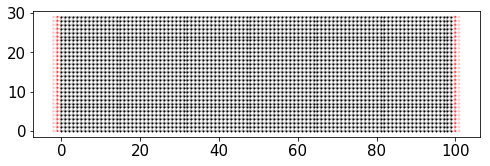

In [21]:
kwant.plot(make_sys(L=100));

In [7]:
U0 = 0.3
salt = 13
energy = 0.2

def plot_wf(phi=0):
    params = SimpleNamespace(phi=phi, U0=U0, salt=salt)
    wfs = kwant.wave_function(sys, energy=energy, args=[params])
    scattering_wf = wfs(0)  # all scattering wave functions from lead 0
    kwant.plotter.map(sys, np.sum(abs(scattering_wf)**2, axis=0));

interact(plot_wf, phi=(0, 0.15, 0.002))

NameError: name 'interact' is not defined

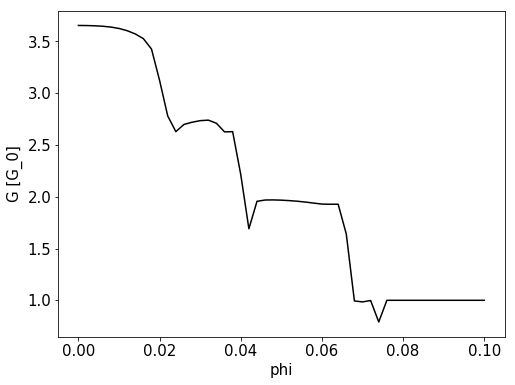

In [8]:
energy = 0.2
U0 = 0.3
salt = 13

phis = np.linspace(0, 0.1, 51)

Gs = []
for phi in phis:
    params = SimpleNamespace(phi=phi, U0=U0, salt=salt)
    smat = kwant.smatrix(sys, energy=energy, args=[params])
    Gs.append(smat.transmission(1, 0))
    
plt.plot(phis, Gs);
plt.ylabel("G [G_0]")
plt.xlabel("phi")

- add some more structure to the problem, for example by using a more interesting shape. Combine this example with the quantum point contact from the previous tutorial!
- write a function that computes the disorder strength necessary to obtain a given mean free path. Use this to choose different disorder strengths and see what happens to the wave function.
- *(probably too long for during the tutorial, but a nice exercise)* Knowing the connection
  between mean free path 
  $l_\text{mfp}$ and disorder strength $U_0$, check the dependence of the conductance at 
  zero magnetic field on the mean free path. In particular, you should (roughly) find
  
  $$ G = \frac{N}{1 + \frac{2}{\pi} \frac{L}{l_\text{mfp}}} $$
  
  where $N$ is the number of channels in the (clean) wire, and $L$ the wire length (see
  Beenakker, Rev. Mod. Phys. 69, 731 (1997). The factor $\frac{2}{\pi}$ is particular for
  2D)

## width scalings

The simplest sanity check is that $N$, the number of modes, is what we think it is. Let's do it:

In [87]:
energy = 0.2
L = 100
U0 = 0
phi = 0


salt = np.random.randint(1000)

Ws = range(50,450,50)

Gs = []
Gcalc = []
for W in Ws:
    params = SimpleNamespace(phi=phi, U0=U0, salt=salt)
    sys = make_sys(L=L, W=W)
    smat = kwant.smatrix(sys, energy=energy, args=[params])
    num_of_modes = np.shape(kwant.wave_function(make_sys(W=W), energy = energy, args=[params])(0))[0]
    Gs.append(smat.transmission(1, 0))
    Gcalc.append(num_of_modes)

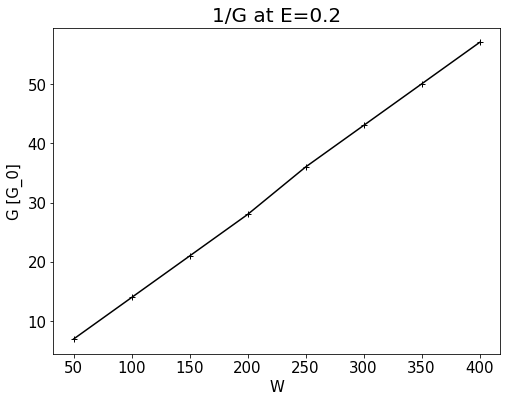

In [88]:
plt.plot(Ws, np.array(Gs), '+', Ws, Gcalc);
plt.ylabel("G [G_0]")
plt.xlabel("W")
plt.title('1/G at E='+str(energy))

Looks fine!

## length scalings

we want to see that the equation above is correct. Let's start with the limit $L \gg l_{mpf}$. We see that $l_{mpf}$ is ~ 48 lattice spacings over $U_0^2$, where we take the energy to be ~1. Let's say we want $l_{mpf} \simeq 10a$, this means we need $U_0 \simeq 2.2$. (Assuming $t=1$, $E\simeq1$).

let's plot the bands first just to get a reference.

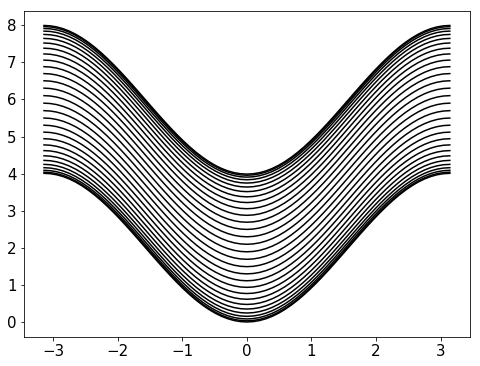

In [47]:
energy = 1
U0 = 2.2
phi = 0
params = SimpleNamespace(phi=phi, U0=U0, salt=salt)
kwant.plotter.bands(make_sys().leads[0], args=[params]);

### plot of the scalings

It looks like the scaling we're getting does not match the formula exactly.

In [ ]:
energy = 1
W = 100
num_of_modes = np.shape(kwant.wave_function(make_sys(W=W), energy = energy, args=[params])(0))[0]
print('number of modes =', num_of_modes)
U0 = 1.2
phi=0

L_mpf = 48*np.sqrt(energy)/U0**2 # note that this assumes t=1, a=1!!
print('L_mpf = ', L_mpf)
salt = np.random.randint(1000)

Ls = range(50,650,10)

Gs = []
Gcalc = []
for L in Ls:
    params = SimpleNamespace(phi=phi, U0=U0, salt=salt)
    sys = make_sys(L=L, W=W)
    smat = kwant.smatrix(sys, energy=energy, args=[params])
    Gs.append(smat.transmission(1, 0))
    Gcalc.append(num_of_modes/(1+(2/np.pi)*L/L_mpf))

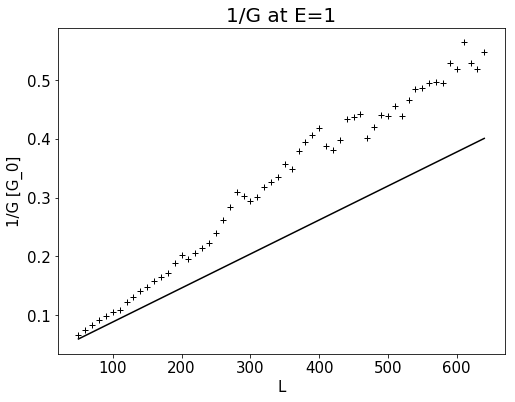

In [77]:
plt.plot(Ls, 1./np.array(Gs), '+', Ls, 1./np.array(Gcalc));
plt.ylabel("1/G [G_0]")
plt.xlabel("L")
plt.title('1/G at E='+str(energy))

Maybe this is because the energy we're using is relatively high so we don't get a parabolic dispersion? Let's try with lower energy.

number of modes = 28
L_mpf =  43.8086787429


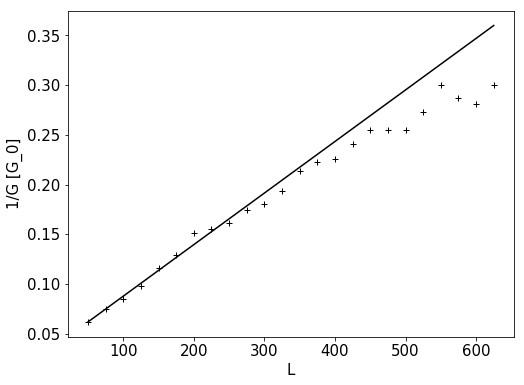

In [80]:
energy = 0.2
W = 200
num_of_modes = np.shape(kwant.wave_function(make_sys(W=W), energy = energy, args=[params])(0))[0]
print('number of modes =', num_of_modes)
U0 = 0.7
phi=0

L_mpf = 48*np.sqrt(energy)/U0**2 # note that this assumes t=1, a=1!!
print('L_mpf = ', L_mpf)
salt = np.random.randint(1000)

Ls = range(50,650,25)

Gs = []
Gcalc = []
for L in Ls:
    params = SimpleNamespace(phi=phi, U0=U0, salt=salt)
    sys = make_sys(L=L, W=W)
    smat = kwant.smatrix(sys, energy=energy, args=[params])
    Gs.append(smat.transmission(1, 0))
    Gcalc.append(num_of_modes/(1+(2/np.pi)*L/L_mpf))
plt.plot(Ls, 1./np.array(Gs), '+', Ls, 1./np.array(Gcalc));
plt.ylabel("1/G [G_0]")
plt.xlabel("L")

Looks much better! This was probably the issue.